In [1]:
import shutil
import os
from google.colab import files

print("Please put your kaggle.json here... (filename must be kaggle.json)\n");
files.upload()

kaggle_json_file = "/content/kaggle.json"
destination_directory = "/root/.kaggle"

try:
  os.mkdir(destination_directory)
except FileExistsError as e:
  print("Kaggle Directory: ", e)

shutil.copyfile(kaggle_json_file, destination_directory + "/kaggle.json")
! chmod 600 /root/.kaggle/kaggle.json
os.remove(kaggle_json_file)
print("kaggle.json is ready to be served!");

Please put your kaggle.json here... (filename must be kaggle.json)



Saving kaggle.json to kaggle.json
kaggle.json is ready to be served!


In [2]:
! pip install -q kaggle
! kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 48.0MB/s]


In [3]:
import zipfile;

zip_path = "/content/emotions-dataset-for-nlp.zip"
dataset_zip =  zipfile.ZipFile(zip_path, "r")

dataset = "train.txt"
dataset_save_path = "/tmp/datasets/"
dataset_zip.extract(dataset, dataset_save_path)
new_dataset_name = "dataset.txt"
os.rename(dataset_save_path + dataset, dataset_save_path + new_dataset_name)
print(new_dataset_name, " has been successfully extracted to tmp folder!");

dataset.txt  has been successfully extracted to tmp folder!


In [4]:
import pandas as pd
dataset = "/tmp/datasets/dataset.txt"
datasets_from_csv = pd.read_csv(dataset, names=['sentence', 'label'], sep=';')
category = pd.get_dummies(datasets_from_csv.label)
datasets_from_csv = datasets_from_csv.drop(columns="label")
datasets_from_csv = pd.concat([datasets_from_csv, category], axis=1)
datasets_from_csv

,sentence,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0
15997,i feel strong and good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0


In [5]:
emotion_labels = ["anger", "fear", "joy", "love", "sadness", "surprise"]
sentence = datasets_from_csv["sentence"].values
labels = datasets_from_csv[emotion_labels].values

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence_train, sentence_test, labels_train, labels_test = train_test_split(sentence, labels, test_size=0.2)
tokenizer = Tokenizer(num_words=40000, oov_token="-")

tokenizer.fit_on_texts(sentence_train)
tokenizer.fit_on_texts(sentence_test)

train_sequence = tokenizer.texts_to_sequences(sentence_train)
test_sequence = tokenizer.texts_to_sequences(sentence_test)

padded_train = pad_sequences(train_sequence)
padded_test = pad_sequences(test_sequence)

In [9]:
import tensorflow.keras.layers as layers
import tensorflow.keras as kr

class FitCallback(kr.callbacks.Callback):
  def on_train_begin(self, logs=None):
    print("Training has been started!")
  def on_train_end(self, logs=None):
    print("Training has ended!")
  def on_epoch_end(self, batch, logs=None):
    qualify_value = 0.90001
    if (logs["accuracy"] >= qualify_value and logs["val_accuracy"] >= qualify_value):
      print("Accuracy and val_accuracy has reached over 90%. Exit training process...")
      self.model.stop_training = True


model = kr.models.Sequential([layers.Embedding(input_dim=40000, output_dim=64),
                             layers.LSTM(128),
                             layers.Dense(128, activation="relu"),
                             layers.Dense(128, activation="relu"),
                             layers.Dropout(0.4),
                             layers.Dense(64, activation="relu"),
                             layers.Dense(64, activation="relu"),
                             layers.Dense(32, activation="relu"),
                             layers.Dense(6, activation="softmax")])

model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

fit_callback = FitCallback()
fit_callback.model = model

num_epochs = 60
history = model.fit(padded_train,
                    labels_train,
                    batch_size=50,
                    steps_per_epoch=50,
                    callbacks=[fit_callback],
                    validation_data=(padded_test, labels_test),
                    epochs=num_epochs,
                    verbose=2)

Training has been started!
Epoch 1/60
50/50 - 9s - loss: 1.6708 - accuracy: 0.2852 - val_loss: 1.5795 - val_accuracy: 0.2956
Epoch 2/60
50/50 - 8s - loss: 1.5941 - accuracy: 0.3132 - val_loss: 1.5784 - val_accuracy: 0.3344
Epoch 3/60
50/50 - 9s - loss: 1.5691 - accuracy: 0.3228 - val_loss: 1.4976 - val_accuracy: 0.3363
Epoch 4/60
50/50 - 8s - loss: 1.3897 - accuracy: 0.3636 - val_loss: 1.2978 - val_accuracy: 0.4087
Epoch 5/60
50/50 - 8s - loss: 1.2788 - accuracy: 0.3792 - val_loss: 1.2295 - val_accuracy: 0.4128
Epoch 6/60
50/50 - 8s - loss: 1.1638 - accuracy: 0.4296 - val_loss: 1.1725 - val_accuracy: 0.4353
Epoch 7/60
50/50 - 8s - loss: 1.1208 - accuracy: 0.4228 - val_loss: 1.1489 - val_accuracy: 0.4387
Epoch 8/60
50/50 - 8s - loss: 1.0829 - accuracy: 0.4444 - val_loss: 1.1121 - val_accuracy: 0.4447
Epoch 9/60
50/50 - 8s - loss: 1.0401 - accuracy: 0.4416 - val_loss: 1.0910 - val_accuracy: 0.4956
Epoch 10/60
50/50 - 8s - loss: 1.0684 - accuracy: 0.4748 - val_loss: 1.0656 - val_accuracy:

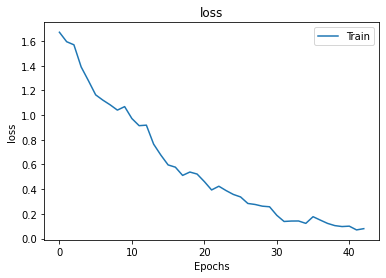

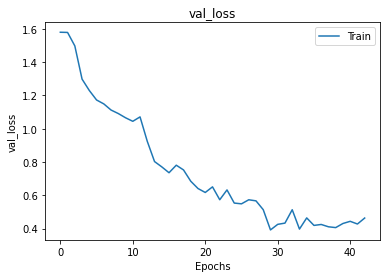

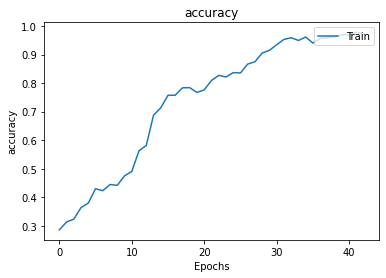

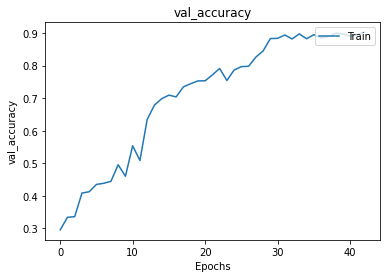

In [10]:
import matplotlib.pyplot as plt

def plot_data(history_keyword):
  plt.plot(history.history[history_keyword])
  plt.title(history_keyword)
  plt.ylabel(history_keyword)
  plt.xlabel("Epochs")
  plt.legend(["Train"], loc="upper right")
  plt.show()

keywords = ["loss", "val_loss", "accuracy", "val_accuracy"]
for keyword in keywords:
  plot_data(keyword)